In [ ]:
#Colab support
!wget https://raw.githubusercontent.com/orel509/AttacksonImplementationsCourseBook/master/Labs/WS2.mat
!wget https://raw.githubusercontent.com/orel509/AttacksonImplementationsCourseBook/master/Labs/hamming_weight.py
!wget https://raw.githubusercontent.com/orel509/AttacksonImplementationsCourseBook/master/Labs/aes_scripts/aes_lib.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sp
from hamming_weight import hamming_weight
#from aes_scripts.aes_crypt_8bit_and_leak import aes_crypt_8bit_and_leak, aes_sbox
from aes_lib import aes_crypt_8bit_and_leak, aes_sbox

#  Differential power analysis and correlation power analysis
DPA = 0
CPA = 1
dpa_or_cpa = CPA  # DPA

In [2]:
#  Make sure the matlab AES scripts are in the path
#  Load WS2, show a few traces
ws2 = sp.loadmat('WS2.mat')
print(np.shape(ws2['traces']))  # D = 200, T = 100000

(200, 100000)


In [3]:
#  shrink it a little so it runs faster
traces = ws2['traces'][:, 0:30000]
input_count = np.shape(traces)[0]
trace_length = np.shape(traces)[1]

<Figure size 432x288 with 0 Axes>

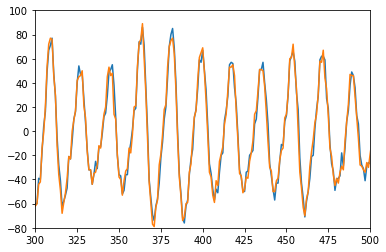

<Figure size 432x288 with 0 Axes>

In [4]:
plt.plot(traces[0, :])
plt.plot(traces[1, :])
plt.xlim([300, 500])
plt.ylim([-80, 100])
plt.figure()

In [5]:
#  We want to guess byte 1 in the key
key_byte_to_guess = 12
classification_output = np.zeros(shape=(2**8, trace_length))
print(np.shape(classification_output))
# #
#  For each key guess
trace_classification = np.zeros(shape=(2**8, input_count))
inputs = ws2['inputs']

(256, 30000)


In [6]:
# guessing the byte of the key and finding the correct guess
for key_guess in range(2**8):
  # For each plaintext input
  for input in range(input_count):
    # Calculate what the value of S[P ^ K] is
    p_xor_k = np.bitwise_xor(inputs[input, key_byte_to_guess - 1], key_guess)
    s_p_xor_k = aes_sbox(p_xor_k, 1)

    if dpa_or_cpa == DPA:
      trace_classification[key_guess, input] = (np.bitwise_and(s_p_xor_k, 1) != 0)
    else:
      trace_classification[key_guess, input] = hamming_weight(s_p_xor_k)

  # % Calculate the mean of each classified set
  if dpa_or_cpa == DPA:
    mean_for_1 = np.mean(traces[trace_classification[key_guess, :] == 1, :])
    mean_for_0 = np.mean(traces[trace_classification[key_guess, :] == 0, :])
    # % Save the difference of means in the table
    classification_output[key_guess, :] = mean_for_1 - mean_for_0
  else:
    shape = np.shape(trace_classification[key_guess, :])
    my_trace = np.reshape(trace_classification[key_guess, :], newshape=(shape[0], 1))

    traces1 = (traces - traces.mean(axis=0))/traces.std(axis=0)  # A matrix
    my_trace = (my_trace - my_trace.mean(axis=0))/my_trace.std(axis=0)  # B matrix
    correlation = (np.dot(my_trace.T, traces1) / my_trace.shape[0])[0]

    classification_output[key_guess, :] = np.transpose(correlation)

  print('[{:02x}]'.format(key_guess), end=" ")
  if (key_guess % 16) == 15:
    print('\n')

[00] [01][02] [03][04] [05][06] [07][08] [09][0a] [0b][0c] [0d][0e] [0f] 

[10] [11][12] [13] [14][15] [16][17] [18][19] [1a][1b] [1c][1d] [1e][1f] 

[20][21] [22][23] [24][25] [26][27] [28][29] [2a][2b] [2c][2d] [2e][2f] 

[30][31] [32][33] [34][35] [36][37] [38][39] [3a][3b] [3c][3d] [3e][3f] 

[40][41] [42][43] [44][45] [46][47] [48][49] [4a][4b] [4c][4d] [4e][4f] 

[50][51] [52][53] [54][55] [56][57] [58][59] [5a][5b] [5c][5d] [5e][5f] 

[60][61] [62][63] [64][65] [66][67] [68][69] [6a][6b] [6c][6d] [6e][6f] 

[70][71][72] [73] [74][75] [76][77] [78][79] [7a][7b] [7c][7d][7e] [7f] 

[80] [81][82] [83] [84] [85][86] [87][88] [89][8a] [8b][8c] [8d][8e][8f] 

[90] [91][92] [93] [94][95] [96][97][98] [99][9a] [9b][9c] [9d][9e] [9f] 

[a0][a1] [a2][a3] [a4][a5] [a6][a7] [a8][a9] [aa][ab] [ac][ad] [ae][af] 

[b0][b1] [b2][b3] [b4][b5] [b6][b7] [b8][b9] [ba][bb] [bc][bd] [be][bf] 

[c0][c1] [c2][c3] [c4][c5] [c6][c7] [c8][c9] [ca][cb] [cc][cd] [ce][cf] 

[d0][d1] [d2][d3] [d4][d5] [d6][d7

<Figure size 432x288 with 0 Axes>

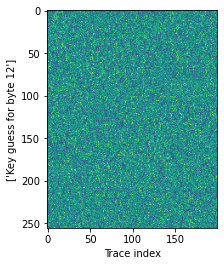

<Figure size 432x288 with 0 Axes>

In [7]:
#  Plot the trace classification matrix
plt.imshow(trace_classification)
# #imagesc(trace_classification)
plt.xlabel('Trace index')
plt.ylabel(['Key guess for byte ' + str(key_byte_to_guess)])
plt.figure()

In [8]:
#  Find out the correct timne and correct key
absolute = np.abs(classification_output)
index = np.unravel_index(np.argmax(absolute, axis=None), absolute.shape)
correct_time = index[1]

absolute = np.abs(classification_output[:, correct_time])
correct_key = np.argmax(absolute)  # this is actually correct_key + 1

<Figure size 432x288 with 0 Axes>

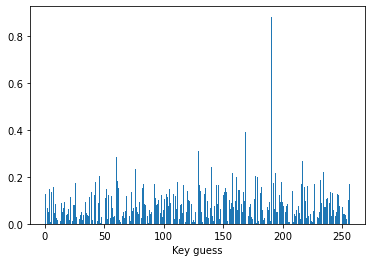

<Figure size 432x288 with 0 Axes>

In [9]:
heights = np.abs(classification_output[:, correct_time])
plt.bar(range(1, np.shape(classification_output)[0] + 1), heights)
plt.xlabel('Key guess')
plt.figure()

<Figure size 432x288 with 0 Axes>

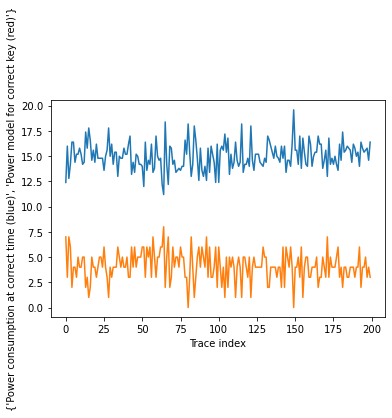

<Figure size 432x288 with 0 Axes>

In [10]:
# #
#  CPA only: show the actual power consumption at correct time, compared to
#  power model
temp = traces[:, correct_time]
plot1 = np.true_divide(traces[:, correct_time], 5)
plt.plot(plot1)
plt.plot(np.transpose(trace_classification[correct_key, :]))
plt.xlabel('Trace index')
plt.ylabel({'Power consumption at correct time (blue)', 'Power model for correct key (red)'})
plt.figure()

<Figure size 432x288 with 0 Axes>

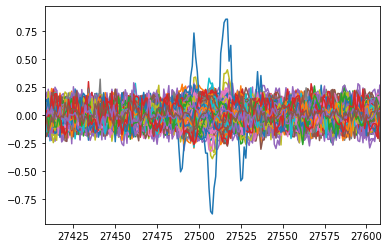

<Figure size 432x288 with 0 Axes>

In [11]:
#  plot the correct key at the correct time
plt.plot(np.transpose(classification_output))
plt.xlim([correct_time - 100, correct_time + 100])
plt.figure()

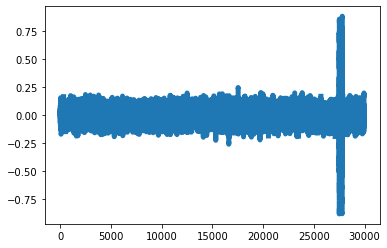

<Figure size 432x288 with 0 Axes>

In [12]:
# hold on
plt.plot(classification_output[correct_key, :], linestyle='dashed', linewidth=5)
# hold off
plt.figure()
plt.show()